# Third Model: Decision Tree Classifier with Reduced Features

The goal of this model is to make a better Decision Tree that can more accurately predict the minority class correctly. Our biggest obstacle was high dimensionality. It was distracting both of our models from focusing on what was important. This time we will tell it what is important.

### Methods:

Feature Selection: I will use domain knowledge select the most important features. The feature importance method was not helpful as all the feature scores were very close to zero.

Leave One Out Encoding: easier to encode the data this way because it will not create as many columns since it leaves one out, reducing dimensionality, works better with a Decision Tree and helps prevent overfitting

Resampling/ Upsampling the Minority Class: to fix class imbalance
OR SMOTE : synthesize new instances of existing dat with KNN


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder

from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, RocCurveDisplay, ConfusionMatrixDisplay
from sklearn.datasets import load_iris

%matplotlib inline

In [3]:
#Load in the dataset
diabetes_df = pd.read_csv('cleaned_diabetes_data.csv', index_col=0)

In [4]:
diabetes_df.columns

Index(['race', 'gender', 'age', 'admission_type_id',
       'discharge_disposition_id', 'admission_source_id', 'time_in_hospital',
       'payer_code', 'medical_specialty', 'num_lab_procedures',
       'num_procedures', 'num_medications', 'number_outpatient',
       'number_emergency', 'number_inpatient', 'diag_1', 'diag_2', 'diag_3',
       'number_diagnoses', 'max_glu_serum', 'A1Cresult', 'metformin',
       'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride',
       'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide',
       'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone',
       'tolazamide', 'examide', 'citoglipton', 'insulin',
       'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone', 'change', 'diabetesMed', 'readmitted'],
      dtype='object')

## Feature Engineering

Adjusting data types of categorical variables

In [5]:
diabetes_df['admission_type_id'] = diabetes_df['admission_type_id'].astype('object')
diabetes_df['admission_source_id'] = diabetes_df['admission_source_id'].astype('object')
diabetes_df['discharge_disposition_id'] = diabetes_df['discharge_disposition_id'].astype('object')

In [6]:
diabetes_df[['time_in_hospital','num_lab_procedures',
       'num_procedures', 'num_medications','number_diagnoses']].corr()

,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_diagnoses
time_in_hospital,1.000000,0.332180,0.188305,0.467897,0.233850
num_lab_procedures,0.332180,1.000000,0.043781,0.258975,0.153981
num_procedures,0.188305,0.043781,1.000000,0.400873,0.086476
num_medications,0.467897,0.258975,0.400873,1.000000,0.259283
number_diagnoses,0.233850,0.153981,0.086476,0.259283,1.000000


### Creating the A1Cmeasurement column: 

I want to see the effect of whether not A1C is measured has some impact on the target variable

In [7]:
diabetes_df['A1Cresult'].value_counts()

A1Cresult
Missing    57128
>8          6239
Norm        3741
>7          2865
Name: count, dtype: int64

In [8]:
temp_table = diabetes_df['A1Cresult'].replace(to_replace=['>8','>7','Norm'], value='Yes')

In [9]:
temp_table

0         Missing
1         Missing
2         Missing
3         Missing
4         Missing
           ...   
101754        Yes
101755        Yes
101756    Missing
101758    Missing
101765    Missing
Name: A1Cresult, Length: 69973, dtype: object

In [10]:
A1Cmeasurement = temp_table.replace(to_replace='Missing', value='No')


In [11]:
A1Cmeasurement = A1Cmeasurement.rename('A1Cmeasurement')

In [12]:
A1Cmeasurement

0          No
1          No
2          No
3          No
4          No
         ... 
101754    Yes
101755    Yes
101756     No
101758     No
101765     No
Name: A1Cmeasurement, Length: 69973, dtype: object

In [14]:
diabetes_df = diabetes_df.join(A1Cmeasurement, how='left')

                   race  gender      age admission_type_id  \
0             Caucasian  Female   [0-10)                 6   
1             Caucasian  Female  [10-20)                 1   
2       AfricanAmerican  Female  [20-30)                 1   
3             Caucasian    Male  [30-40)                 1   
4             Caucasian    Male  [40-50)                 1   
...                 ...     ...      ...               ...   
101754        Caucasian  Female  [70-80)                 1   
101755            Other  Female  [40-50)                 1   
101756            Other  Female  [60-70)                 1   
101758        Caucasian  Female  [80-90)                 1   
101765        Caucasian    Male  [70-80)                 1   

       discharge_disposition_id admission_source_id  time_in_hospital  \
0                            25                   1                 1   
1                             1                   7                 3   
2                             1     

In [15]:
diabetes_df

,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,num_lab_procedures,...,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted,A1Cmeasurement
0,Caucasian,Female,[0-10),6,25,1,1,Unknown,Pediatrics-Endocrinology,41,...,No,No,No,No,No,No,No,No,Otherwise,No
1,Caucasian,Female,[10-20),1,1,7,3,Unknown,Unknown,59,...,Up,No,No,No,No,No,Ch,Yes,Otherwise,No
2,AfricanAmerican,Female,[20-30),1,1,7,2,Unknown,Unknown,11,...,No,No,No,No,No,No,No,Yes,Otherwise,No
3,Caucasian,Male,[30-40),1,1,7,2,Unknown,Unknown,44,...,Up,No,No,No,No,No,Ch,Yes,Otherwise,No
4,Caucasian,Male,[40-50),1,1,7,1,Unknown,Unknown,51,...,Steady,No,No,No,No,No,Ch,Yes,Otherwise,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101754,Caucasian,Female,[70-80),1,1,7,9,Unknown,Unknown,50,...,Steady,No,No,No,No,No,Ch,Yes,Otherwise,Yes
101755,Other,Female,[40-50),1,1,7,14,MD,Unknown,73,...,Up,No,No,No,No,No,Ch,Yes,Otherwise,Yes
101756,Other,Female,[60-70),1,1,7,2,MD,Unknown,46,...,Steady,No,No,No,No,No,No,Yes,Otherwise,No
101758,Caucasian,Female,[80-90),1,1,7,5,MC,Unknown,76,...,Up,No,No,No,No,No,Ch,Yes,Otherwise,No


In [38]:
diabetes_df['max_glu_serum'].value_counts()

max_glu_serum
Missing    66625
Norm        1700
>200         936
>300         712
Name: count, dtype: int64

In [39]:
temp_table_2 = diabetes_df['max_glu_serum'].replace(to_replace=['>200','>300','Norm'], value='Yes')

In [40]:
Glucose_Measured = temp_table_2.replace(to_replace='Missing', value='No')

In [42]:
Glucose_Measured = Glucose_Measured.rename('Glucose_Measured')

In [43]:
diabetes_df = diabetes_df.join(Glucose_Measured, how='left')
diabetes_df

,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,num_lab_procedures,...,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted,A1Cmeasurement,Glucose_Measured
0,Caucasian,Female,[0-10),6,25,1,1,Unknown,Pediatrics-Endocrinology,41,...,No,No,No,No,No,No,No,Otherwise,No,No
1,Caucasian,Female,[10-20),1,1,7,3,Unknown,Unknown,59,...,No,No,No,No,No,Ch,Yes,Otherwise,No,No
2,AfricanAmerican,Female,[20-30),1,1,7,2,Unknown,Unknown,11,...,No,No,No,No,No,No,Yes,Otherwise,No,No
3,Caucasian,Male,[30-40),1,1,7,2,Unknown,Unknown,44,...,No,No,No,No,No,Ch,Yes,Otherwise,No,No
4,Caucasian,Male,[40-50),1,1,7,1,Unknown,Unknown,51,...,No,No,No,No,No,Ch,Yes,Otherwise,No,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101754,Caucasian,Female,[70-80),1,1,7,9,Unknown,Unknown,50,...,No,No,No,No,No,Ch,Yes,Otherwise,Yes,No
101755,Other,Female,[40-50),1,1,7,14,MD,Unknown,73,...,No,No,No,No,No,Ch,Yes,Otherwise,Yes,No
101756,Other,Female,[60-70),1,1,7,2,MD,Unknown,46,...,No,No,No,No,No,No,Yes,Otherwise,No,No
101758,Caucasian,Female,[80-90),1,1,7,5,MC,Unknown,76,...,No,No,No,No,No,Ch,Yes,Otherwise,No,No


In [44]:
diabetes_df.isna().value_counts()

race   gender  age    admission_type_id  discharge_disposition_id  admission_source_id  time_in_hospital  payer_code  medical_specialty  num_lab_procedures  num_procedures  num_medications  number_outpatient  number_emergency  number_inpatient  diag_1  diag_2  diag_3  number_diagnoses  max_glu_serum  A1Cresult  metformin  repaglinide  nateglinide  chlorpropamide  glimepiride  acetohexamide  glipizide  glyburide  tolbutamide  pioglitazone  rosiglitazone  acarbose  miglitol  troglitazone  tolazamide  examide  citoglipton  insulin  glyburide-metformin  glipizide-metformin  glimepiride-pioglitazone  metformin-rosiglitazone  metformin-pioglitazone  change  diabetesMed  readmitted  A1Cmeasurement  Glucose_Measured
False  False   False  False              False                     False                False             False       False              False               False           False            False              False             False             False   False   False   False        

So we created 2 new columns to signify whether or not glucose and Hemoglobin A1C were measured during the patient's visit. If these are statistically significant variables, we will be able to use them as predictors for our model

In [46]:
import pandas as pd
from scipy.stats import chi2_contingency

# Create a contingency table to 
contingency_table = pd.crosstab(diabetes_df['A1Cmeasurement'], diabetes_df['readmitted'])

# Perform the Chi-Square test
chi2, p, dof, expected = chi2_contingency(contingency_table)
chi2, p, dof, expected 


(6.355505830669563,
 0.011701757602602935,
 1,
 array([[ 5124.72605148, 52003.27394852],
        [ 1152.27394852, 11692.72605148]]))

The p-value of is .01, which is less than alpha .05. We can reject the null and say that this is in fact a statistically significant variable for our target.

In [21]:
contingency_table

readmitted,<30,Otherwise
A1Cmeasurement,,
No,5199,51929
Yes,1078,11767


In [22]:
import pandas as pd
from scipy.stats import chi2_contingency

# Create a contingency table to 
contingency_table = pd.crosstab(diabetes_df['A1Cresult'], diabetes_df['readmitted'])

# Perform the Chi-Square test
chi2, p, dof, expected = chi2_contingency(contingency_table)
chi2, p, dof, expected 


(7.260008315545734,
 0.06405633904985746,
 3,
 array([[  257.00777443,  2607.99222557],
        [  559.67591785,  5679.32408215],
        [ 5124.72605148, 52003.27394852],
        [  335.59025624,  3405.40974376]]))

The actual A1C result is not statistically significant here so we won't include this in our reduced dataframe.

In [25]:
import pandas as pd
from scipy.stats import chi2_contingency

# Create a contingency table to 
contingency_table = pd.crosstab(diabetes_df['age'], diabetes_df['readmitted'])

# Perform the Chi-Square test
chi2, p, dof, expected = chi2_contingency(contingency_table)
chi2, p, dof, expected 


(188.13382228360737,
 1.0114177173089188e-35,
 9,
 array([[1.37250225e+01, 1.39274977e+02],
        [4.79030197e+01, 4.86096980e+02],
        [1.00560459e+02, 1.02043954e+03],
        [2.41488631e+02, 2.45051137e+03],
        [6.12512769e+02, 6.21548723e+03],
        [1.10777976e+03, 1.12412202e+04],
        [1.40694937e+03, 1.42770506e+04],
        [1.59228202e+03, 1.61577180e+04],
        [9.95916339e+02, 1.01060837e+04],
        [1.57882612e+02, 1.60211739e+03]]))

Age is statistically signficant.

In [69]:
import pandas as pd
from scipy.stats import chi2_contingency

# Create a contingency table to 
contingency_table = pd.crosstab(diabetes_df['gender'], diabetes_df['readmitted'])

# Perform the Chi-Square test
chi2, p, dof, expected = chi2_contingency(contingency_table)
chi2, p, dof, expected 


(0.6113260258097654,
 0.7366348140607145,
 2,
 array([[3.33966577e+03, 3.38893342e+04],
        [2.93706511e+03, 2.98039349e+04],
        [2.69118088e-01, 2.73088191e+00]]))

Gender is not statistically significant

In [71]:
import pandas as pd
from scipy.stats import chi2_contingency

# Create a contingency table to 
contingency_table = pd.crosstab(diabetes_df['race'], diabetes_df['readmitted'])

# Perform the Chi-Square test
chi2, p, dof, expected = chi2_contingency(contingency_table)
chi2, p, dof, expected 


(18.210752754882044,
 0.002693546379127181,
 5,
 array([[1.13253862e+03, 1.14924614e+04],
        [4.37765424e+01, 4.44223458e+02],
        [4.69090769e+03, 4.76010923e+04],
        [1.34559044e+02, 1.36544096e+03],
        [1.03161934e+02, 1.04683807e+03],
        [1.72056165e+02, 1.74594384e+03]]))

Race is statistically significant

In [26]:
import pandas as pd
from scipy.stats import chi2_contingency

# Create a contingency table to 
contingency_table = pd.crosstab(diabetes_df['admission_type_id'], diabetes_df['readmitted'])

# Perform the Chi-Square test
chi2, p, dof, expected = chi2_contingency(contingency_table)
chi2, p, dof, expected 


(18.872430526679967,
 0.008596497460928193,
 7,
 array([[3.18151404e+03, 3.22844860e+04],
        [1.14841659e+03, 1.16535834e+04],
        [1.23659762e+03, 1.25484024e+04],
        [8.07354265e-01, 8.19264573e+00],
        [2.76832807e+02, 2.80916719e+03],
        [4.05112429e+02, 4.11088757e+03],
        [1.61470853e+00, 1.63852915e+01],
        [2.61044546e+01, 2.64895545e+02]]))

Admission type is statistically significant

In [28]:
import pandas as pd
from scipy.stats import chi2_contingency

# Create a contingency table to 
contingency_table = pd.crosstab(diabetes_df['payer_code'], diabetes_df['readmitted'])

# Perform the Chi-Square test
chi2, p, dof, expected = chi2_contingency(contingency_table)
chi2, p, dof, expected 


(133.09886182224145,
 4.735512091613653e-20,
 17,
 array([[3.04731382e+02, 3.09226862e+03],
        [1.01367813e+01, 1.02863219e+02],
        [1.16169308e+02, 1.17883069e+03],
        [1.73939991e+02, 1.76506001e+03],
        [3.33706430e+01, 3.38629357e+02],
        [8.97060295e-02, 9.10293971e-01],
        [3.57388821e+02, 3.62661118e+03],
        [1.77456467e+03, 1.80074353e+04],
        [1.94213554e+02, 1.97078645e+03],
        [2.87059294e+00, 2.91294071e+01],
        [5.80398011e+01, 5.88960199e+02],
        [5.56177383e+00, 5.64382262e+01],
        [4.09956555e+01, 4.16004345e+02],
        [3.31912309e+00, 3.36808769e+01],
        [2.96299015e+02, 3.00670098e+03],
        [1.66404685e+02, 1.68859532e+03],
        [2.72840889e+03, 2.76865911e+04],
        [1.04956054e+01, 1.06504395e+02]]))

Payer code is statistically significant

In [29]:
import pandas as pd
from scipy.stats import chi2_contingency

# Create a contingency table to 
contingency_table = pd.crosstab(diabetes_df['time_in_hospital'], diabetes_df['readmitted'])

# Perform the Chi-Square test
chi2, p, dof, expected = chi2_contingency(contingency_table)
chi2, p, dof, expected 


(274.18868404668183,
 5.92540801142587e-51,
 13,
 array([[  939.22212854,  9530.77787146],
        [ 1092.44002687, 11085.55997313],
        [ 1120.15918997, 11366.84081003],
        [  845.29991568,  8577.70008432],
        [  600.76127935,  6096.23872065],
        [  453.01544882,  4596.98455118],
        [  350.03292699,  3551.96707301],
        [  255.03424178,  2587.96575822],
        [  171.42822231,  1739.57177769],
        [  135.09728038,  1370.90271962],
        [  106.57076301,  1081.42923699],
        [   82.08101696,   832.91898304],
        [   68.26628843,   692.73371157],
        [   57.59127092,   584.40872908]]))

Time in hospital is statistically significant

In [30]:
import pandas as pd
from scipy.stats import chi2_contingency

# Create a contingency table to 
contingency_table = pd.crosstab(diabetes_df['num_lab_procedures'], diabetes_df['readmitted'])

# Perform the Chi-Square test
chi2, p, dof, expected = chi2_contingency(contingency_table)
chi2, p, dof, expected 


(227.33783363021905,
 2.190847541795524e-09,
 115,
 array([[2.02197390e+02, 2.05180261e+03],
        [6.93427608e+01, 7.03657239e+02],
        [4.53912509e+01, 4.60608749e+02],
        [2.63735727e+01, 2.67626427e+02],
        [1.91073843e+01, 1.93892616e+02],
        [1.78514999e+01, 1.81148500e+02],
        [2.32338616e+01, 2.35766138e+02],
        [2.38618038e+01, 2.42138196e+02],
        [6.10898061e+01, 6.19910194e+02],
        [5.21192031e+01, 5.28880797e+02],
        [4.30588941e+01, 4.36941106e+02],
        [3.31015249e+01, 3.35898475e+02],
        [2.64632787e+01, 2.68536721e+02],
        [2.32338616e+01, 2.35766138e+02],
        [2.53868063e+01, 2.57613194e+02],
        [3.21147585e+01, 3.25885241e+02],
        [4.23412459e+01, 4.29658754e+02],
        [4.31486002e+01, 4.37851400e+02],
        [6.36912809e+01, 6.46308719e+02],
        [5.15809669e+01, 5.23419033e+02],
        [4.79030197e+01, 4.86096980e+02],
        [4.44941906e+01, 4.51505809e+02],
        [5.36442056e+01, 

Number of lab procedures is statistically significant

In [31]:
import pandas as pd
from scipy.stats import chi2_contingency

# Create a contingency table to 
contingency_table = pd.crosstab(diabetes_df['diag_1'], diabetes_df['readmitted'])

# Perform the Chi-Square test
chi2, p, dof, expected = chi2_contingency(contingency_table)
chi2, p, dof, expected 


(1434.0837881144912,
 9.395940707022191e-54,
 694,
 array([[0.08970603, 0.91029397],
        [0.71764824, 7.28235176],
        [0.17941206, 1.82058794],
        ...,
        [0.08970603, 0.91029397],
        [0.08970603, 0.91029397],
        [0.71764824, 7.28235176]]))

Primary diagnosis is statistically significant

In [33]:
import pandas as pd
from scipy.stats import chi2_contingency

# Create a contingency table to 
contingency_table = pd.crosstab(diabetes_df['num_medications'], diabetes_df['readmitted'])

# Perform the Chi-Square test
chi2, p, dof, expected = chi2_contingency(contingency_table)
chi2, p, dof, expected 


(240.31918893838173,
 1.8562809970227165e-19,
 74,
 array([[1.93765024e+01, 1.96623498e+02],
        [3.50750575e+01, 3.55924942e+02],
        [6.35118689e+01, 6.44488131e+02],
        [1.02803110e+02, 1.04319689e+03],
        [1.42901705e+02, 1.45009830e+03],
        [1.87665014e+02, 1.90433499e+03],
        [2.38528332e+02, 2.42047167e+03],
        [2.89122533e+02, 2.93387747e+03],
        [3.24107884e+02, 3.28889212e+03],
        [3.45727038e+02, 3.50827296e+03],
        [3.60349120e+02, 3.65665088e+03],
        [3.80532977e+02, 3.86146702e+03],
        [3.82057980e+02, 3.87694202e+03],
        [3.44650565e+02, 3.49734943e+03],
        [3.49225573e+02, 3.54377443e+03],
        [3.26888771e+02, 3.31711123e+03],
        [2.92082832e+02, 2.96391717e+03],
        [2.63556315e+02, 2.67444369e+03],
        [2.32159204e+02, 2.35584080e+03],
        [2.11437111e+02, 2.14556289e+03],
        [1.83448830e+02, 1.86155117e+03],
        [1.63803210e+02, 1.66219679e+03],
        [1.40210524e+02, 

Number of medications is statistically significant

In [36]:
import pandas as pd
from scipy.stats import chi2_contingency

# Create a contingency table to 
contingency_table = pd.crosstab(diabetes_df['max_glu_serum'], diabetes_df['readmitted'])

# Perform the Chi-Square test
chi2, p, dof, expected = chi2_contingency(contingency_table)
chi2, p, dof, expected 


(6.9942155454614605,
 0.07208237144251027,
 3,
 array([[   83.96484358,   852.03515642],
        [   63.87069298,   648.12930702],
        [ 5976.66421334, 60648.33578666],
        [  152.5002501 ,  1547.4997499 ]]))

The glucose result is not statistically significant

In [52]:
import pandas as pd
from scipy.stats import chi2_contingency

# Create a contingency table to 
contingency_table = pd.crosstab(diabetes_df['Glucose_Measured'], diabetes_df['readmitted'])

# Perform the Chi-Square test
chi2, p, dof, expected = chi2_contingency(contingency_table)
chi2, p, dof, expected 



(5.892279472467756,
 0.015207403378144534,
 1,
 array([[ 5976.66421334, 60648.33578666],
        [  300.33578666,  3047.66421334]]))

Glucose measured is statistically significant!

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


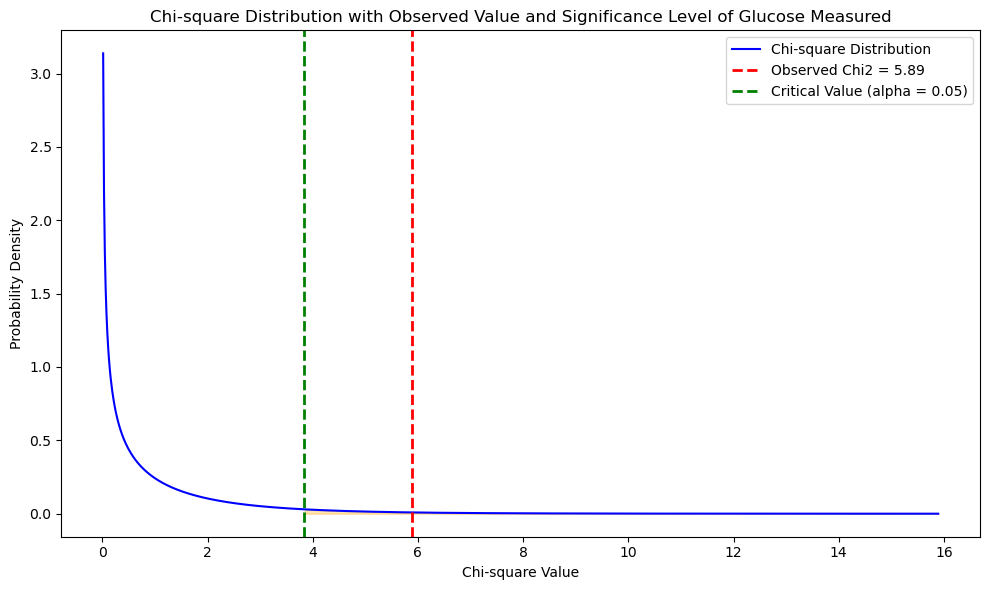

In [62]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency, chi2

# Generate the contingency table
contingency_table = pd.crosstab(diabetes_df['Glucose_Measured'], diabetes_df['readmitted'])

# Perform the Chi-Square test
chi2_stat, p, dof, expected = chi2_contingency(contingency_table)

# Define the critical chi-square value for alpha = 0.05
alpha = 0.05
critical_value = chi2.ppf(1 - alpha, dof)

# Generate values for the chi-square distribution curve
x_values = np.linspace(0, chi2_stat + 10, 1000)
y_values = chi2.pdf(x_values, dof)

# Plot the chi-square distribution curve
plt.figure(figsize=(10, 6))
plt.plot(x_values, y_values, label="Chi-square Distribution", color="blue")

# Add a vertical line for the observed chi-square value
plt.axvline(chi2_stat, color="red", linestyle="--", linewidth=2, label=f"Observed Chi2 = {chi2_stat:.2f}")

# Add a vertical line for the critical value at alpha = 0.05
plt.axvline(critical_value, color="green", linestyle="--", linewidth=2, label=f"Critical Value (alpha = {alpha})")

# Fill the rejection region
plt.fill_between(x_values, 0, y_values, where=(x_values >= critical_value), color='orange', alpha=0.3)

# Display p-value, chi-square, and significance level
plt.text(chi2_stat + 1, max(y_values) * 0.6, f"p-value: {p:.4f}", color='red', ha='center')
plt.text(critical_value + 1, max(y_values) * 0.7, f"alpha = {alpha}", color='green', ha='center')
plt.xlabel("Chi-square Value")
plt.ylabel("Probability Density")
plt.title("Chi-square Distribution with Observed Value and Significance Level of Glucose Measured")
plt.legend()

plt.tight_layout()
plt.savefig('Glucose_Measured_Significance')


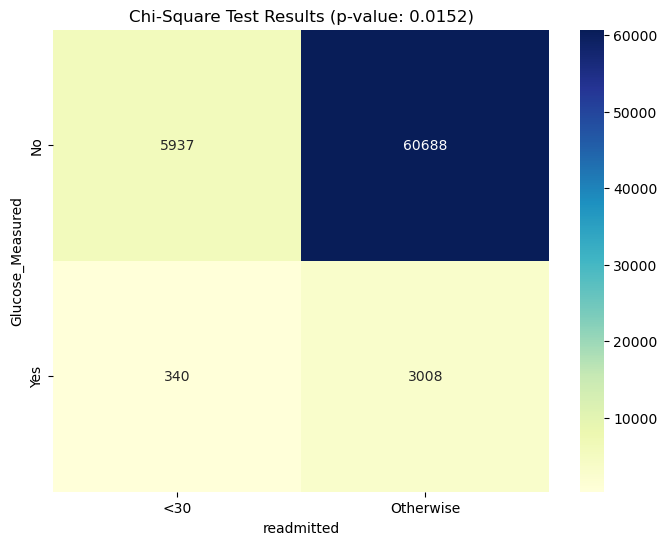

In [53]:
plt.figure(figsize=(8, 6))
sns.heatmap(contingency_table, annot=True, fmt="d", cmap="YlGnBu")
plt.title(f"Chi-Square Test Results (p-value: {p:.4f})")
plt.show()


In [48]:
import pandas as pd
from scipy.stats import chi2_contingency

# Create a contingency table to 
contingency_table = pd.crosstab(diabetes_df['num_lab_procedures'], diabetes_df['readmitted'])

# Perform the Chi-Square test
chi2, p, dof, expected = chi2_contingency(contingency_table)
chi2, p, dof, expected 


(227.33783363021905,
 2.190847541795524e-09,
 115,
 array([[2.02197390e+02, 2.05180261e+03],
        [6.93427608e+01, 7.03657239e+02],
        [4.53912509e+01, 4.60608749e+02],
        [2.63735727e+01, 2.67626427e+02],
        [1.91073843e+01, 1.93892616e+02],
        [1.78514999e+01, 1.81148500e+02],
        [2.32338616e+01, 2.35766138e+02],
        [2.38618038e+01, 2.42138196e+02],
        [6.10898061e+01, 6.19910194e+02],
        [5.21192031e+01, 5.28880797e+02],
        [4.30588941e+01, 4.36941106e+02],
        [3.31015249e+01, 3.35898475e+02],
        [2.64632787e+01, 2.68536721e+02],
        [2.32338616e+01, 2.35766138e+02],
        [2.53868063e+01, 2.57613194e+02],
        [3.21147585e+01, 3.25885241e+02],
        [4.23412459e+01, 4.29658754e+02],
        [4.31486002e+01, 4.37851400e+02],
        [6.36912809e+01, 6.46308719e+02],
        [5.15809669e+01, 5.23419033e+02],
        [4.79030197e+01, 4.86096980e+02],
        [4.44941906e+01, 4.51505809e+02],
        [5.36442056e+01, 

Number of Lab procedures is statistically significant

In [63]:
import pandas as pd
from scipy.stats import chi2_contingency

# Create a contingency table to 
contingency_table = pd.crosstab(diabetes_df['insulin'], diabetes_df['readmitted'])

# Perform the Chi-Square test
chi2, p, dof, expected = chi2_contingency(contingency_table)
chi2, p, dof, expected 


(50.626250842006954,
 5.87644764524392e-11,
 3,
 array([[  656.73784174,  6664.26215826],
        [ 3073.14915753, 31184.85084247],
        [ 1939.17523902, 19677.82476098],
        [  607.93776171,  6169.06223829]]))

Insulin measurement is also statistically significant

In [67]:
import pandas as pd
from scipy.stats import chi2_contingency

# Create a contingency table to 
contingency_table = pd.crosstab(diabetes_df['change'], diabetes_df['readmitted'])

# Perform the Chi-Square test
chi2, p, dof, expected = chi2_contingency(contingency_table)
chi2, p, dof, expected 


(14.983439258895487,
 0.00010845884202377609,
 1,
 array([[ 2824.93257399, 28666.06742601],
        [ 3452.06742601, 35029.93257399]]))

Change in medication is statistically significant

In [68]:
import pandas as pd
from scipy.stats import chi2_contingency

# Create a contingency table to 
contingency_table = pd.crosstab(diabetes_df['diabetesMed'], diabetes_df['readmitted'])

# Perform the Chi-Square test
chi2, p, dof, expected = chi2_contingency(contingency_table)
chi2, p, dof, expected 


(54.05200384318759,
 1.9525288585115278e-13,
 1,
 array([[ 1496.29657153, 15183.70342847],
        [ 4780.70342847, 48512.29657153]]))

Prescribed diabetes medication is also statisically significant

## Feature Selection

Based on domain knowledge and statistical significance of variables


In [76]:
reduced_df = diabetes_df[['race', 'age', 'payer_code',
                                           'admission_type_id','time_in_hospital',
                                           'num_lab_procedures','diag_1', 'num_medications',
                                           'Glucose_Measured', 'A1Cmeasurement',
                                           'insulin','change', 
                                           'diabetesMed', 'readmitted']]
reduced_df

,race,age,payer_code,admission_type_id,time_in_hospital,num_lab_procedures,diag_1,num_medications,Glucose_Measured,A1Cmeasurement,insulin,change,diabetesMed,readmitted
0,Caucasian,[0-10),Unknown,6,1,41,250.83,1,No,No,No,No,No,Otherwise
1,Caucasian,[10-20),Unknown,1,3,59,276,18,No,No,Up,Ch,Yes,Otherwise
2,AfricanAmerican,[20-30),Unknown,1,2,11,648,13,No,No,No,No,Yes,Otherwise
3,Caucasian,[30-40),Unknown,1,2,44,8,16,No,No,Up,Ch,Yes,Otherwise
4,Caucasian,[40-50),Unknown,1,1,51,197,8,No,No,Steady,Ch,Yes,Otherwise
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101754,Caucasian,[70-80),Unknown,1,9,50,574,33,No,Yes,Steady,Ch,Yes,Otherwise
101755,Other,[40-50),MD,1,14,73,592,26,No,Yes,Up,Ch,Yes,Otherwise
101756,Other,[60-70),MD,1,2,46,996,17,No,No,Steady,No,Yes,Otherwise
101758,Caucasian,[80-90),MC,1,5,76,292,22,No,No,Up,Ch,Yes,Otherwise


In [77]:
reduced_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 69973 entries, 0 to 101765
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   race                69973 non-null  object
 1   age                 69973 non-null  object
 2   payer_code          69973 non-null  object
 3   admission_type_id   69973 non-null  object
 4   time_in_hospital    69973 non-null  int64 
 5   num_lab_procedures  69973 non-null  int64 
 6   diag_1              69973 non-null  object
 7   num_medications     69973 non-null  int64 
 8   Glucose_Measured    69973 non-null  object
 9   A1Cmeasurement      69973 non-null  object
 10  insulin             69973 non-null  object
 11  change              69973 non-null  object
 12  diabetesMed         69973 non-null  object
 13  readmitted          69973 non-null  object
dtypes: int64(3), object(11)
memory usage: 8.0+ MB


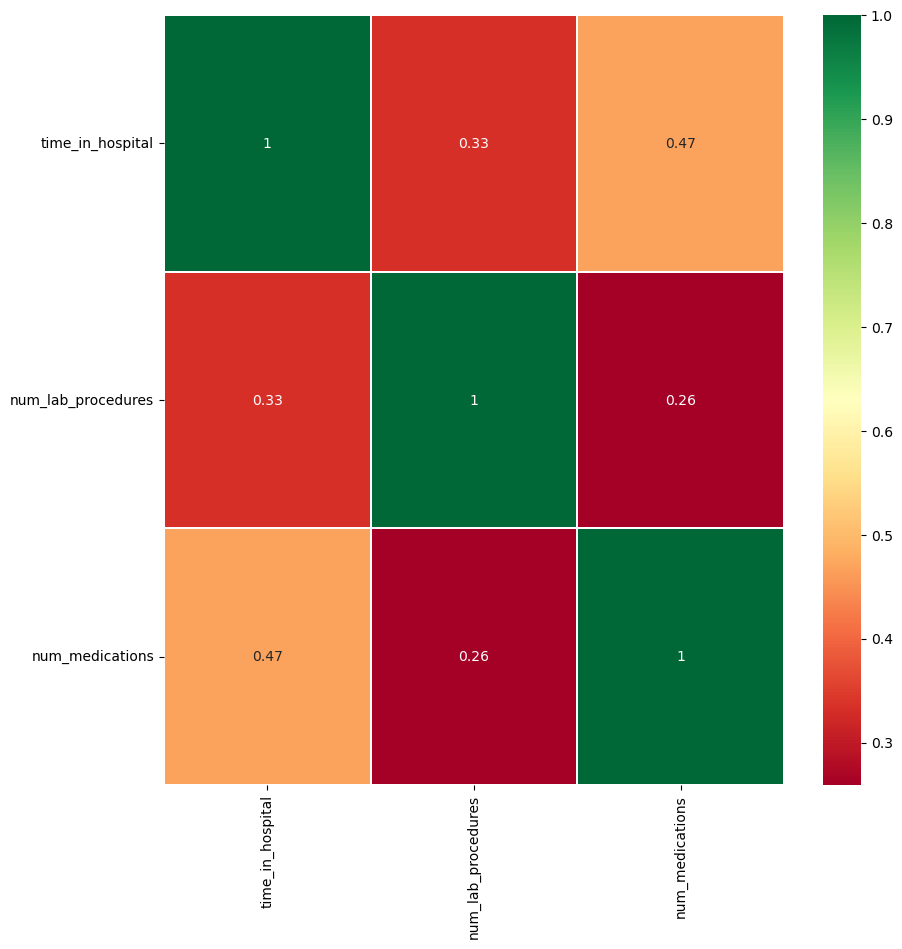

In [78]:

sns.heatmap(reduced_df.corr(numeric_only=True), annot=True, cmap='RdYlGn', linewidths=0.2)
fig = plt.gcf()
fig.set_size_inches(10, 10)

In [79]:
X_reduced = reduced_df.drop('readmitted', axis=1)
y_reduced = reduced_df['readmitted']
X_reduced.columns

Index(['race', 'age', 'payer_code', 'admission_type_id', 'time_in_hospital',
       'num_lab_procedures', 'diag_1', 'num_medications', 'Glucose_Measured',
       'A1Cmeasurement', 'insulin', 'change', 'diabetesMed'],
      dtype='object')

## Train-test split

In [80]:
X_train, X_test, y_train, y_test = train_test_split(X_reduced, y_reduced, test_size=.25, random_state=1000)

In [81]:
X_train

,race,age,payer_code,admission_type_id,time_in_hospital,num_lab_procedures,diag_1,num_medications,Glucose_Measured,A1Cmeasurement,insulin,change,diabetesMed
81694,Caucasian,[70-80),MC,3,2,39,8,8,No,Yes,Steady,No,Yes
9467,Caucasian,[70-80),Unknown,5,9,27,403,24,Yes,No,Steady,No,Yes
21070,Caucasian,[50-60),Unknown,1,3,41,428,9,No,No,No,Ch,Yes
21436,Caucasian,[70-80),Unknown,3,3,48,427,27,No,No,No,No,No
2811,Caucasian,[20-30),Unknown,1,2,45,958,12,No,No,Up,Ch,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...
80416,Caucasian,[40-50),MD,3,1,20,414,12,No,No,No,No,No
43054,AfricanAmerican,[40-50),MC,3,3,41,414,29,No,No,No,No,No
83367,Caucasian,[70-80),SP,3,2,57,410,27,No,No,Down,Ch,Yes
25644,Caucasian,[70-80),MC,1,4,49,434,15,No,No,Steady,No,Yes


In [82]:
X_test

,race,age,payer_code,admission_type_id,time_in_hospital,num_lab_procedures,diag_1,num_medications,Glucose_Measured,A1Cmeasurement,insulin,change,diabetesMed
17211,Caucasian,[60-70),Unknown,2,2,31,519,19,No,No,Down,Ch,Yes
38859,Caucasian,[70-80),SP,2,6,1,250.4,7,No,No,Up,Ch,Yes
77091,Asian,[50-60),UN,2,4,48,79,14,No,Yes,No,No,No
1504,Caucasian,[0-10),Unknown,1,1,46,79,3,No,No,No,No,No
53765,Caucasian,[90-100),MC,1,8,63,250.8,18,No,No,Steady,No,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...
54440,AfricanAmerican,[30-40),MD,5,2,43,577,9,No,Yes,Up,Ch,Yes
53365,Caucasian,[60-70),Unknown,2,2,41,486,13,No,No,No,Ch,Yes
23788,AfricanAmerican,[60-70),Unknown,1,5,66,250.11,12,No,No,Steady,No,Yes
54824,Caucasian,[70-80),MC,3,7,50,250.82,25,No,No,No,No,No


## Encoding categoricals with LeaveOneOut Encoder

We use a leave-one-out encoder as it creates a single column for each categorical variable instead of creating a column for each level of the categorical variable like one-hot-encoding. This makes interpreting the impact of categorical variables with feature impact easier. 

In [85]:
pip install category_encoders


Note: you may need to restart the kernel to use updated packages.


In [89]:
X_train.dtypes

race                  object
age                   object
payer_code            object
admission_type_id     object
time_in_hospital       int64
num_lab_procedures     int64
diag_1                object
num_medications        int64
Glucose_Measured      object
A1Cmeasurement        object
insulin               object
change                object
diabetesMed           object
dtype: object

In [95]:
y_train.head()

81694    Otherwise
9467     Otherwise
21070    Otherwise
21436    Otherwise
2811     Otherwise
Name: readmitted, dtype: object

In [90]:
import category_encoders as ce

encoder = ce.LeaveOneOutEncoder(return_df=True)
X_train_loo = encoder.fit_transform(X_train,y_train)

AttributeError: 'numpy.ndarray' object has no attribute 'groupby'

In [26]:
#Function that separates numeric variables from categoricals
from sklearn.preprocessing import OneHotEncoder, StandardScaler


#Take in a train and test data
def transform_features(X_train,X_test):
    
    #Separate numeric and categorical columns for X_train
    numerics_train_df = X_train.select_dtypes(include=['int64', 'float64'])
    categories_train_df = X_train.select_dtypes(include='object')
    
    #Separate numeric and categorical columns for X_test
    numerics_test_df = X_test.select_dtypes(include=['int64', 'float64'])
    categories_test_df = X_test.select_dtypes(include='object')
    
    #Correlation matrix of X_train numeric columns
    corr_matrix = numerics_train_df.corr()

    #Scale numeric columns using StandardScaler for both X_train and X_test
    ss = StandardScaler()
    scaled_numerics_train = pd.DataFrame(ss.fit_transform(numerics_train_df), columns=numerics_train_df.columns, index=numerics_train_df.index)
    scaled_numerics_test = pd.DataFrame(ss.transform(numerics_test_df), columns=numerics_test_df.columns, index=numerics_test_df.index)
    
    #Initialize and fit OneHotEncoder on X_train categorical columns
    ohe = OneHotEncoder(drop='first', sparse_output=False)
    encoded_train_array = ohe.fit_transform(categories_train_df)
    
    #Create encoded DataFrame for X_train with prefixed column names
    encoded_train_df = pd.DataFrame(encoded_train_array, 
                                    columns=[f'{col}_{category}' for col, categories in zip(categories_train_df.columns, ohe.categories_) for category in categories[1:]],
                                    index=categories_train_df.index)
    
    #Transform X_test categorical columns using the fitted encoder
    encoded_test_array = ohe.transform(categories_test_df)
    encoded_test_df = pd.DataFrame(encoded_test_array, 
                                   columns=encoded_train_df.columns,  # Ensures column alignment with X_train
                                   index=categories_test_df.index)

    #Concatenate scaled numerics and encoded categories for X_train and X_test
    X_train_transformed = pd.concat([scaled_numerics_train, encoded_train_df], axis=1)
    X_test_transformed = pd.concat([scaled_numerics_test, encoded_test_df], axis=1)
    
    return corr_matrix, X_train_transformed, X_test_transformed

    

In [28]:
#simplified helper function, only for x_train
'''import pandas as pd
from sklearn.preprocessing import StandardScaler, OneHotEncoder

def transform_features(df):
    # Separate numeric and categorical columns
    numerics_df = df.select_dtypes(include=['int64', 'float64'])
    categories_df = df.select_dtypes(exclude=['int64', 'float64'])
    
    # Correlation matrix of numeric columns
    corr_matrix = numerics_df.corr()

    # Scale numeric columns using StandardScaler
    ss = StandardScaler()
    scaled_numerics = pd.DataFrame(ss.fit_transform(numerics_df), columns=numerics_df.columns, index=numerics_df.index)
    
    # Initialize OneHotEncoder
    ohe = OneHotEncoder(drop='first', sparse_output=False)
    encoded_columns = []
    
    # Iterate over categorical columns and one-hot encode with unique prefixes
    for col in categories_df.columns:
        # Create a new DataFrame for the encoded column(s)
        encoded_col = pd.DataFrame(ohe.fit_transform(categories_df[[col]]), 
                                   columns=[f'{col}_{category}' for category in ohe.categories_[0]], 
                                   index=categories_df.index)
        # Append the new encoded columns to the list
        encoded_columns.append(encoded_col)

    # Concatenate all encoded columns into a single DataFrame
    encoded_df = pd.concat(encoded_columns, axis=1)

    # Concatenate the scaled numeric features and the encoded categorical features
    X_train_transformed = pd.concat([scaled_numerics, encoded_df], axis=1)
    
    return corr_matrix, X_train_transformed

'''